<div id="todo_description"><h1>(Optional) Extended Practice: Importances and Coefficients</h1>
    

<ul><li>The following practice assignment is much longer than a typical practice assignment. <ul><li>You may skip this assignment if you feel comfortable with what you have learned thus far. </li><li>Note: while the target grades (G1-G3) are different, all of the features from this data set are the same as those from the Student Performance lessons. They require the same preprocessing steps as you've seen in the previous lessons.</li></ul></li></ul><h3>Task</h3>
<ul><li>For this assignment, we will be using the alternative version of the student performance dataset that we've been exploring in the lessons this week. You will create a model to predict the students' final grades (G3), but using the Math grades version of the data. The features are the same as the dataset used in the lessons, but the G1, G2, and G3 columns are the students' grades for Math instead of Portuguese. </li></ul>
<ul><li>First, preprocess the data.<ul><li>A: Perform train-test-split with G3 as the target.</li><li>B: Use a ColumnTransformer with the required preprocessing steps <ul><li>Drop any unnecessary binary categories using the drop='if_binary' argument for OneHotEncoder.</li><li>Don't forget to add <code>verbose_feature_names_out=False</code></li></ul></li><li>C: Create DataFrame versions of your X_train and X_test data using the correct feature names.</li></ul></li><li>Second, fit a tree-based model of your choice (that produces feature importances).<ul><li>A: Evaluate its performance on the training and test data.</li><li>B: extract and visualize the feature importances determined by the model.</li><li>C: Answer what were the top 5 most important features?</li></ul></li><li>Third, apply sklearn's permutation_importance.<ul><li>A: visualize the permutation importances.</li><li>B: Answer what are the top 5 most important features the same as the top 5 most important features (according to our built-in importance)?</li></ul></li><li>Fourth, Fit a sklearn LinearRegression model.<ul><li>A: Evaluate its performance on the training &amp; test data.</li><li>B: visualize the model's top 15 largest coefficients (according to absolute value).</li><li>C: Select the 3 largest coefficients (by absolute value) and explain what they mean and what insights they might provide.</li></ul></li></ul>
<h3></h3><h3>The Data<a href="http://localhost:8888/notebooks/ASSIGNMENTS/04_Core%202%20-%20Global%20Explanations%20with%20Shap.ipynb#The-Data" class="anchor-link"></a></h3>
<ul><li>Student Performance - Math<ul><li><a href="https://docs.google.com/spreadsheets/d/1EbTcrapgIgMETN5H9Khw9N92k4OLN1Zu/edit?usp=sharing&amp;ouid=103333507259828193129&amp;rtpof=true&amp;sd=true" rel="nofollow" target="_blank">Share URL</a></li><li>Direct Link:</li><li><a href="https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx" rel="nofollow" target="_blank">https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx</a></li><li>Note: the dataset is an Excel document, and you will need to specify that <code>sheet_name='mat'</code> in pd.read_excel</li></ul></li><li>Original Source &amp; Data Dictionary:<ul><li><a href="https://archive.ics.uci.edu/ml/datasets/student+performance" rel="nofollow" target="_blank">https://archive.ics.uci.edu/ml/datasets/student+performance</a></li></ul></li></ul><p><br></p>

# SOLUTION

In [1]:
## Our standard import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## Preprocess the data.

- A: Perform train-test-split with G3 as the target.
- B: Use a ColumnTransformer with the required preprocessing steps
    - Drop any unnecessary binary categories using the drop='if_binary' argument for OneHotEncoder.
    - Don't forget to add verbose_feature_names_out=False
- C: Create DataFrame versions of your X_train and X_test data using the correct feature names.

In [2]:
## Load in data
FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"


df = pd.read_excel(FILE, sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    float64
 3   address     395 non-null    object 
 4   famsize     395 non-null    object 
 5   Pstatus     395 non-null    object 
 6   Medu        395 non-null    float64
 7   Fedu        395 non-null    float64
 8   Mjob        395 non-null    object 
 9   Fjob        395 non-null    object 
 10  reason      395 non-null    object 
 11  guardian    395 non-null    object 
 12  traveltime  395 non-null    float64
 13  studytime   395 non-null    float64
 14  failures    395 non-null    float64
 15  schoolsup   395 non-null    object 
 16  famsup      395 non-null    object 
 17  paid        395 non-null    object 
 18  activities  395 non-null    object 
 19  nursery     395 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,6.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,6.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,4.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,10.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,15.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,10.0


## Preprocess the Data

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
y = df['G3']
X = df.drop(columns='G3')

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
215,GP,F,17.0,U,LE3,T,3.0,2.0,other,other,reputation,mother,2.0,2.0,0.0,no,no,yes,no,yes,yes,yes,no,4.0,4.0,4.0,1.0,3.0,1.0,2.0,14.0,15.0
48,GP,M,15.0,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,3.0,2.0,2.0,5.0,2.0,15.0,15.0
303,GP,F,17.0,U,GT3,T,3.0,2.0,health,health,reputation,father,1.0,4.0,0.0,no,yes,yes,yes,no,yes,yes,no,5.0,2.0,2.0,1.0,2.0,5.0,0.0,17.0,17.0
160,GP,M,17.0,R,LE3,T,2.0,1.0,at_home,other,course,mother,2.0,1.0,2.0,no,no,no,yes,yes,no,yes,yes,3.0,3.0,2.0,2.0,2.0,5.0,0.0,7.0,6.0
60,GP,F,16.0,R,GT3,T,4.0,4.0,health,teacher,other,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,no,no,2.0,4.0,4.0,2.0,3.0,4.0,6.0,10.0,11.0


In [5]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False)
                        )

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x135c71f40>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x135c71f10>)],
                  verbose_feature_names_out=False)

In [6]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()


X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.0,1.0,2.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,9.0,10.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
338,18.0,3.0,3.0,1.0,4.0,0.0,5.0,3.0,3.0,1.0,1.0,1.0,7.0,16.0,15.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
291,17.0,4.0,3.0,1.0,3.0,0.0,4.0,2.0,2.0,1.0,2.0,3.0,0.0,15.0,15.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


## Second, fit a tree-based model of your choice (that produces feature importances).

- A: Evaluate its performance on the training and test data.
- B: extract and visualize the feature importances determined by the model.
- C: Answer what were the top 5 most important features?

In [7]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    

### A: Evaluate its performance on the training and test data.

In [8]:
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.98	RMSE= 0.66
Test Data:	R^2= 0.91	RMSE= 1.24


### B: extract and visualize the feature importances determined by the model.

In [9]:
feature_importance = pd.Series(reg.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

age           0.015323
Medu          0.004930
Fedu          0.004105
traveltime    0.002238
studytime     0.008951
Name: Feature Importances, dtype: float64

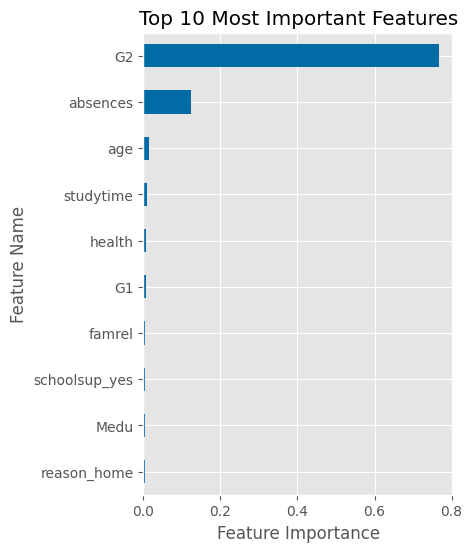

In [10]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

### C: Answer what were the top 5 most important features?

- G2
- absences
- age
- studytime
- health

#### What does it mean that they were "important"?

- An "important' feature is one that was used extensively/repeatedly by the model when during the training process. Feature Importance does not indicate directionality.

## Third, apply sklearn's permutation_importance.

In [11]:
from sklearn.inspection import permutation_importance

r = permutation_importance(reg, X_train_df, y_train ,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

### A: visualize the permutation importances.

In [12]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
perm_importances.head()

age           0.021882
Medu          0.004599
Fedu          0.003292
traveltime    0.001490
studytime     0.010038
Name: permutation importance, dtype: float64

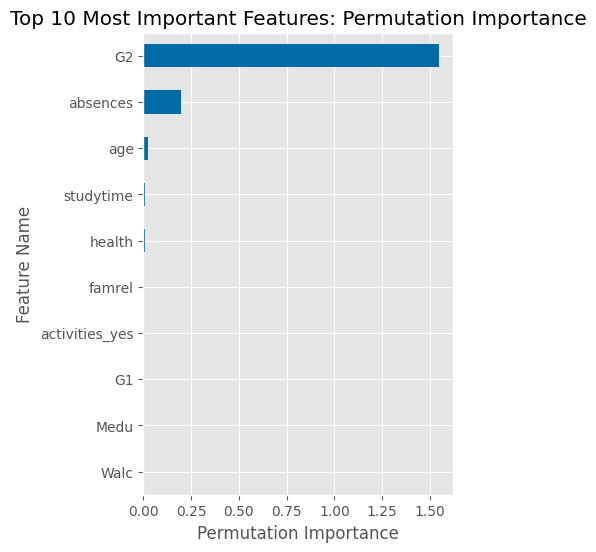

In [13]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

### B: Answer what are the top 5 most important features the same as the top 5 most important features (according to our built-in importance)?

- G2
- absences
- age
- studytikme
- reason_home

#### Are they the same features that your model has as the top 5 important?


- The first top 4 are the same, but the 5th is different. It is reason_home in permutation importances (categorical), but health in the feature importances (numeric)

## Fourth, Fit a sklearn LinearRegression model.

## Linear Regression

### A: Evaluate its performance on the training & test data.

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.85	RMSE= 1.83
Test Data:	R^2= 0.81	RMSE= 1.85


### B: visualize the model's top 15 largest coefficients (according to absolute value).

#### MANUAL WAY

In [16]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

age          -0.220805
Medu          0.291554
Fedu         -0.178754
traveltime    0.187384
studytime    -0.215277
Name: Coefficients, dtype: float64

In [17]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

intercept        -0.948559
Fjob_services    -0.540326
reason_home      -0.417471
activities_yes   -0.338971
romantic_yes     -0.289609
Medu              0.291554
reason_other      0.299188
famrel            0.309943
Fjob_at_home      0.325395
schoolsup_yes     0.342220
Fjob_health       0.377169
school_MS         0.382554
Pstatus_T         0.384430
higher_yes        0.823032
G2                0.991225
Name: Coefficients, dtype: float64

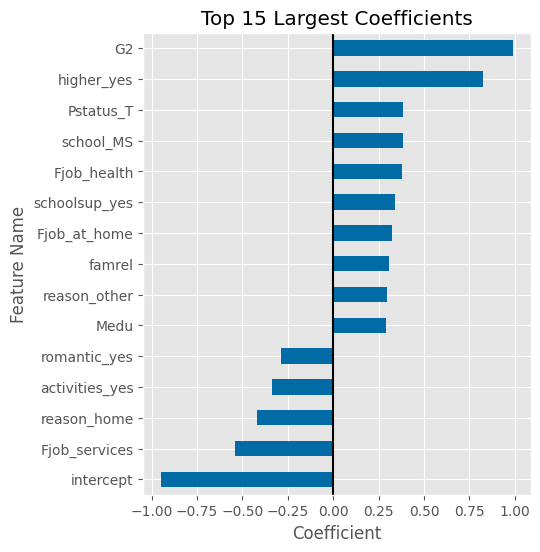

In [18]:
## sort features and keep top_n and set title
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');


#### FUNCTION WAY

In [19]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

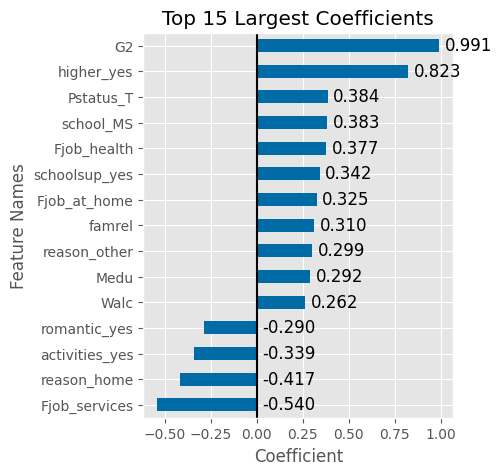

In [20]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

### C: Select the 3 largest coefficients (by absolute value) and explain what they mean and what insights they might provide.

- The 3 largest coefficients are for: 
    - "G2"- for every 1 point increase in their G2 grade, their predicted G3 grade increases 0.99 points. 
    - "higher_yes" - if the student intends to go to pursue higher education, their predicted G3 grade increases by 0.82 points.
    - "Pstatus_T" - if the students parents live together, their predicted G3 grade increases by 0.38 points.
    